In [1]:
import os
import glob
import itertools
import json
import importlib

import matplotlib as mpl
import scipy.stats as spstats
import dill as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import statsmodels.api as sm


In [2]:
import analyze2p.plotting as pplot
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.gratings.utils as gutils
import analyze2p.extraction.rois as roiutils
import analyze2p.retinotopy.utils as retutils
import analyze2p.utils as hutils
import analyze2p.aggregate_datasets as aggr

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
%matplotlib notebook

In [4]:
# import sys
# !{sys.executable} -m pip install shapely

# Plotting params

In [6]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)
# src dirs
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
traceid = 'traces001'


# Load data

In [7]:
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
meta = sdata[sdata.experiment.isin(['rfs', 'rfs10'])].copy()
all_dkeys = [(va, dk) for (va, dk), g in meta.groupby(['visual_area', 'datakey'])]
CELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
                                  if (va, dk) in all_dkeys])
CELLS[['visual_area', 'animalid', 'session', 'fovnum']]\
            .drop_duplicates().groupby(['visual_area']).count()

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets


,animalid,session,fovnum
visual_area,,,
Li,17,17,17
Lm,18,18,18
V1,19,19,19


In [9]:
response_type='dff'
do_spherical_correction=False
# Get RF fit description (tag for which RF analysis to load)
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                                   do_spherical_correction=do_spherical_correction)
data_id = '%s_%s' % (traceid, rf_fit_desc)
print(data_id)
# Set output dir
dst_dir = os.path.join(aggregate_dir, 'receptive-fields', 
                       '%s__%s' % (traceid, rf_fit_desc))
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)

traces001_fit-2dgaus_dff-no-cutoff
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff


In [15]:
# #### Load fit results from measured
# animalid = 'JC097'
# session ='20190616'
# fov='FOV1_zoom2p0x'
# curr_rfname = 'rfs'
# fit_results, fit_params = rfutils.load_fit_results(
#                                     animalid, session, fov,
#                                     experiment=curr_rfname,
#                                     traceid=traceid,
#                                     fit_desc=rf_fit_desc)


In [12]:
# Load RF fit params for good rois
# rfdata = rfutils.cycle_and_load(rf_meta, CELLS, reliable_only=True, 
#                         fit_desc=rf_fit_desc, traceid=traceid, verbose=False)
rfdata = rfutils.aggregate_rfdata(meta, CELLS, fit_desc=rf_fit_desc,
                                 reliable_only=False)
# Get ROI positions
rfdata = aggr.add_roi_positions(rfdata)

N dpaths: 62, N unfit: 0
N datasets included: 67, N sessions excluded: 4


In [13]:
# Get cell counts for all cells
all_cell_counts = rfdata.groupby(['visual_area', 'datakey'])['cell']\
                    .count().reset_index()
print(all_cell_counts.groupby(['visual_area']).sum())

             cell
visual_area      
Li            646
Lm            456
V1           1339


In [14]:
# Save counts
counts_outfile = os.path.join(dst_dir, 'all_cell_counts.csv')
all_cell_counts.to_csv (r'%s' % counts_outfile, index=False, header=True)
print(counts_outfile)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/all_cell_counts.csv


## Compare rf-5 / rf-10

In [15]:
#### Current output dir
curr_dst_dir = os.path.join(dst_dir, 'rfs5_v_rfs10')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/rfs5_v_rfs10


In [16]:
counts = rfdata.groupby(['visual_area', 'animalid', 'datakey', 'experiment'])['cell']\
            .count().reset_index()
print(counts.groupby(['visual_area', 'experiment']).sum())

                        cell
visual_area experiment      
Li          rfs           60
            rfs10        586
Lm          rfs          388
            rfs10         68
V1          rfs          662
            rfs10        677


<IPython.core.display.Javascript object>


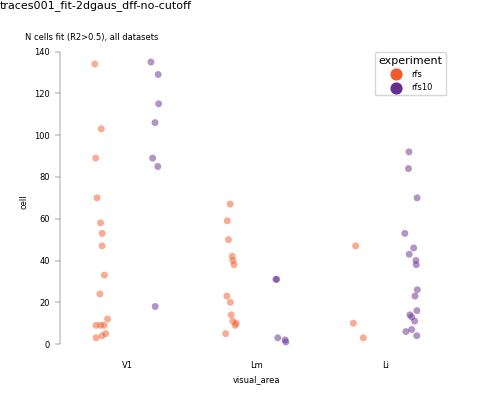

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/rfs5_v_rfs10


In [17]:
rf_colors={'rfs': '#f15a29', 'rfs10': '#662d91'}

fig, ax = pl.subplots()
sns.stripplot(x='visual_area', y='cell', hue='experiment', data=counts,
             ax=ax, dodge=True, order=visual_areas,
             palette=rf_colors, alpha=0.5)
# sns.stripplot(x='visual_area', y='cell', hue='experiment', data=counts_all,
#              ax=ax, dodge=True, order=visual_areas,
#              palette=rf_colors)
pplot.label_figure(fig, data_id)
fig.text(0.05, 0.9, "N cells fit (R2>0.5), all datasets")
sns.despine(bottom=True, offset=2, trim=True)
ax.tick_params(which='both', axis='x', size=0)

pl.savefig(os.path.join(curr_dst_dir, 'counts_by_fov.svg'))
print(curr_dst_dir)

In [18]:
cells_w_both = pd.concat([g for (va, dk, ri), g in \
                rfdata.groupby(['visual_area', 'datakey', 'cell']) \
                if 'rfs' in g['experiment'].values and 'rfs10' in g['experiment'].values])
cells_w_both.groupby(['experiment', 'visual_area']).count()

x0   y0  fwhm_x  fwhm_y  theta  offset  amplitude  \
experiment visual_area                                                       
rfs        Li            49   49      49      49     49      49         49   
           Lm            10   10      10      10     10      10         10   
           V1           220  220     220     220    220     220        220   
rfs10      Li            49   49      49      49     49      49         49   
           Lm            10   10      10      10     10      10         10   
           V1           220  220     220     220    220     220        220   

                         r2  cell  datakey  ...  aniso_index  animalid  fov  \
experiment visual_area                      ...                               
rfs        Li            49    49       49  ...           49        49   49   
           Lm            10    10       10  ...           10        10   10   
           V1           220   220      220  ...          220       220  220   
rfs10      Li            49    49       49  ...           49        49   49   
           Lm            10    10       10  ...           10        10   10   
           V1           220   220      220  ...          220       220  220   

                        session  fov_xpos  fov_xpos_pix  fov_ypos  \
experiment visual_area                                              
rfs        Li                49        49            49        49   
           Lm                10        10            10        10   
           V1               220       220           220       220   
rfs10      Li                49        49            49        49   
           Lm                10        10            10        10   
           V1               220       220           220       220   

                        fov_ypos_pix  ml_pos  ap_pos  
experiment visual_area                                
rfs        Li                     49      49      49  
           Lm                     10      10      10  
           V1                    220     220     220  
rfs10      Li                     49      49      49  
           Lm                     10      10      10  
           V1                    220     220     220  

[6 rows x 34 columns]

In [19]:
cells_w_both.columns

Index(['x0', 'y0', 'fwhm_x', 'fwhm_y', 'theta', 'offset', 'amplitude', 'r2',
       'cell', 'datakey', 'visual_area', 'experiment', 'std_x', 'std_y',
       'fwhm_avg', 'std_avg', 'area', 'fx', 'fy', 'ratio_xy', 'theta_c',
       'theta_Mm_deg', 'major_axis', 'minor_axis', 'anisotropy', 'theta_Mm_c',
       'aniso_index', 'animalid', 'fov', 'session', 'fov_xpos', 'fov_xpos_pix',
       'fov_ypos', 'fov_ypos_pix', 'ml_pos', 'ap_pos'],
      dtype='object')

#### Correlation of metrics for rf-5 v rf-10

<IPython.core.display.Javascript object>


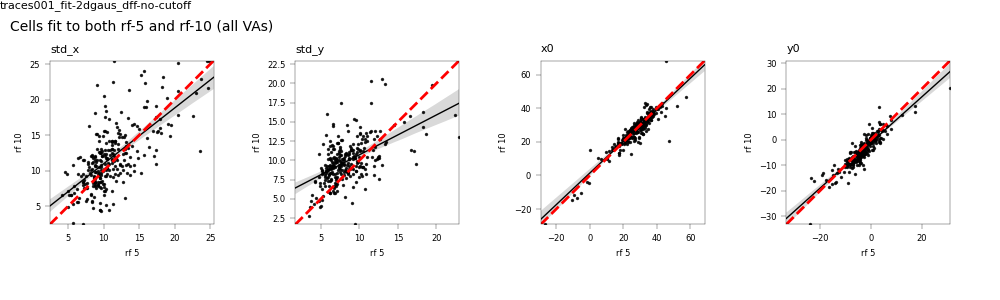

Wilcoxon paired test:
... param: std_x (p=0.00)
... param: std_y (p=0.00)
... param: y0 (p=0.00)


In [21]:
params_to_check = ['std_x', 'std_y', 'x0', 'y0'] #, 'aniso_index']
fig, axn = pl.subplots(1, len(params_to_check), figsize=(10,3))
print("Wilcoxon paired test:")
for pi, par in enumerate(params_to_check):
    ax = axn[pi]
    ax.set_title(par,loc='left')
    v1 = cells_w_both[cells_w_both.experiment=='rfs'][par].values
    v2 = cells_w_both[cells_w_both.experiment=='rfs10'][par].values
    vmin = min([np.min(v1), np.min(v2)])
    vmax = max([np.max(v1), np.max(v2)])
    ax.set_ylim([vmin, vmax]); ax.set_xlim([vmin, vmax]);
    ax.set_aspect('equal')
    sns.regplot(x=v1, y=v2, ax=ax, color='k', truncate=False,
                scatter_kws={'s':2}, line_kws={'lw': 1})
    ax.set_xlabel('rf 5'); ax.set_ylabel('rf 10');
    ax.plot([vmin, vmax], [vmin, vmax], 'r--', lw=2)
    # Annotate w stats
    stat, p =  spstats.wilcoxon(np.array(v1), np.array(v2))
    if p<0.05:
        print("... param: %s (p=%.2f)" % (par, p))
pl.subplots_adjust(left=0.05, right=0.95, bottom=0.15, top=0.9, wspace=0.5, hspace=0.5)    
fig.text(0.01, 0.9, 'Cells fit to both rf-5 and rf-10 (all VAs)', fontsize=10)

pplot.label_figure(fig, data_id)
figname = 'allparams__cells_w_both'
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
# print(curr_dst_dir, figname)

#### Split by VA

<IPython.core.display.Javascript object>


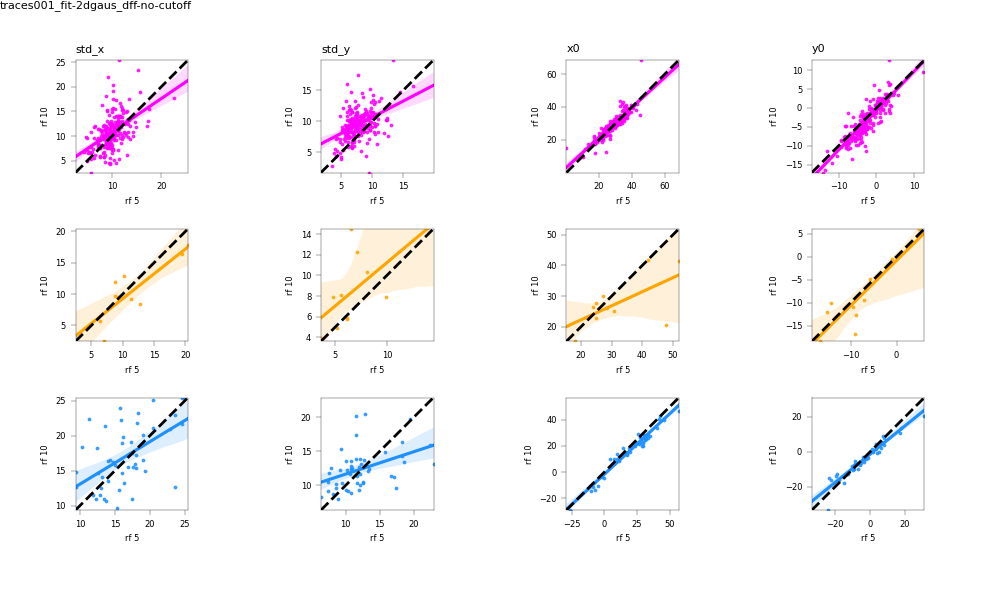

...[V1] param: std_x (p=0.00)
...[V1] param: std_y (p=0.00)
...[Li] param: x0 (p=0.00)
...[V1] param: x0 (p=0.00)
...[V1] param: y0 (p=0.00)


In [22]:
#params_to_check = ['std_x', 'std_y', 'x0', 'y0', 'anisotropy', 'aniso_index']
params_to_check = ['std_x', 'std_y', 'x0', 'y0'] #, 'aniso_index']
fig, axn = pl.subplots(3, len(params_to_check), figsize=(10,6))
for pi, par in enumerate(params_to_check):
    for va, vg in cells_w_both.groupby(['visual_area']):
        vi = visual_areas.index(va)
        ax = axn[vi, pi]
        if vi==0:
            ax.set_title(par,loc='left')
        v1 = vg[vg.experiment=='rfs'][par].values
        v2 = vg[vg.experiment=='rfs10'][par].values
        vmin = min([np.min(v1), np.min(v2)])
        vmax = max([np.max(v1), np.max(v2)])
        ax.set_ylim([vmin, vmax]); ax.set_xlim([vmin, vmax]);
        ax.set_aspect('equal')
        #ax.scatter(v1, v2, s=5, color=area_colors[va])
        sns.regplot(x=v1, y=v2, ax=ax, color=area_colors[va], truncate=False,
                    scatter_kws={'s':3})
        ax.set_xlabel('rf 5'); ax.set_ylabel('rf 10');
        ax.plot([vmin, vmax], [vmin, vmax], 'k--', lw=2)
        # Annotate w stats
        stat, p =  spstats.wilcoxon(np.array(v1), np.array(v2))
        if p<0.05:
            print("...[%s] param: %s (p=%.2f)" % (va, par, p))
pl.subplots_adjust(left=0.05, right=0.95, bottom=0.15, top=0.9, wspace=0.5, hspace=0.5)
pplot.label_figure(fig, data_id)

figname = 'allparams_byVA__cells_w_both'
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
# print(curr_dst_dir, figname)

<IPython.core.display.Javascript object>


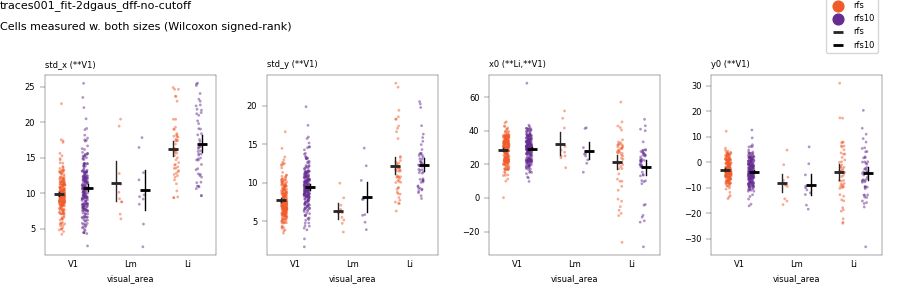

[std_x] ----------------------
[std_y] ----------------------
[x0] ----------------------
[y0] ----------------------


In [23]:
fontsize=6
point_size=2
#params_to_check = ['std_x', 'std_y', 'fx', 'fy','x0', 'y0', 'anisotropy', 'aniso_index', 'theta'] # 'theta'] #, 'theta_Mm_deg']
params_to_check = ['std_x', 'std_y', 'x0', 'y0'] #, 'aniso_index']
fig, axn = pl.subplots(1, len(params_to_check), 
                       figsize=(9,3), sharex=True, sharey=False)
fig.patch.set_alpha(1)
for ai, metric in enumerate(params_to_check):
    print("[%s] ----------------------" % metric)
    ax=axn[ai]
    sns.stripplot(x='visual_area', y=metric, data=cells_w_both,
                 hue='experiment', ax=ax, dodge=0.5, 
                  order=visual_areas, s=2, zorder=-1, 
                 palette=rf_colors, alpha=0.5)
    sns.pointplot(x='visual_area', y=metric, data=cells_w_both,
                  estimator=spstats.circmean if 'theta' in metric else np.mean,
                 hue='experiment', ax=ax, dodge=0.5, join=False,
                  order=visual_areas, ci=95, zorder=-1, color='k',
                  markers='_', scale=1, errwidth=1)
    # Annotate w stats
    info_str=[]
    for va, vg in cells_w_both.groupby(['visual_area']):
        v1 = vg[vg.experiment=='rfs'][metric].values
        v2 = vg[vg.experiment=='rfs10'][metric].values
        stat, p =  spstats.wilcoxon(np.array(v1), np.array(v2))
        if round(p, 2)<0.05:
            info_str.append('**%s' % va if p<0.01 else '*%s' % va)
    title_str = '%s (%s)' % (metric, ','.join(info_str)) \
                        if len(info_str)>0 else '%s (n.s.)' % metric
    ax.set_title(title_str, loc='left', fontsize=fontsize)
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_ylabel('')
    ax.legend_.remove()
axn[-1].legend(bbox_to_anchor=(1,1.1), loc='lower right')
pl.subplots_adjust(top=0.75, bottom=0.15, left=0.05, right=0.98, wspace=0.3, hspace=0.5)
fig.text(0.0, 0.9, 'Cells measured w. both sizes (Wilcoxon signed-rank)', fontsize=8)
pplot.label_figure(fig, data_id)

figname = 'comparestimsize__cells_w_both'
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
# print(curr_dst_dir, figname)

#### Look at THETA specifically

In [44]:
cells_w_both['theta'].max()

6.282272560700279

<IPython.core.display.Javascript object>


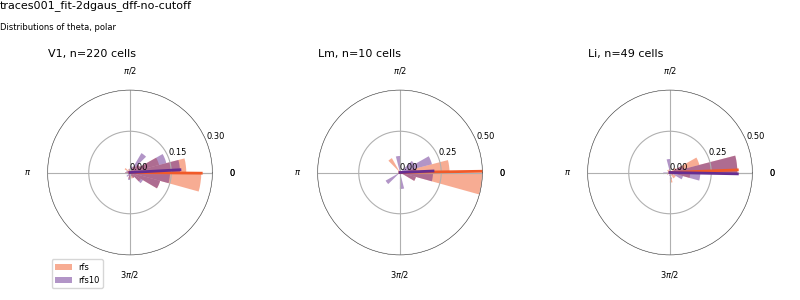

In [25]:
bin_size = 15
bins=50
ai = 1
#ecolors=rf_colors['rfs', rf_colors['rfs10']] #['r', 'b']

fig = pl.figure(figsize=(8,3))
for va, vg in cells_w_both.groupby(['visual_area']):
    ai = visual_areas.index(va)
    polar_ax = fig.add_subplot(1, 3, ai+1, projection="polar")
    for exp, eg in vg.groupby(['experiment']):
        ecol = rf_colors[exp]
        thetas = eg['theta'].values
        cmean = spstats.circmean(eg['theta'].values)
#         # bin data for our polar histogram
#         counts, t_bins = np.histogram(thetas, bins=bins)
#         # Normalise counts to compute areas
#         area = counts / thetas.size
#         # Compute corresponding radii from areas
#         radius = (area / np.pi)**.5
#         polar_ax.bar(t_bins[:-1], radius, align='edge', color=ecol, alpha=0.2,
#                     label=exp)
        degrees = np.array([np.rad2deg(v) for v in thetas])
        weights = np.ones_like(degrees)/len(degrees)
        a , b = np.histogram(degrees, bins=np.arange(0, 360+bin_size, bin_size),
                            weights=weights)
        centers = np.deg2rad(np.ediff1d(b)//2 + b[:-1])
        polar_ax.bar(centers, a, width=np.deg2rad(bin_size), 
                       bottom=0.0, color=ecol, edgecolor='none',
                    label=exp, alpha=0.5)
        polar_ax.plot([0, cmean], [0, max(a)], color=ecol, lw=2)
        # Label angles according to convention
        maxy=0.3 if va=='V1' else 0.5
        polar_ax.set_yticks(np.linspace(0, maxy, 3))
        polar_ax.set_ylim([0, maxy])
        polar_ax.set_xticks([0, np.pi/2, np.pi, np.pi*(3/2.), np.pi*2])
        polar_ax.set_xticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3\pi/2$', r'$0$'])
        polar_ax.set_title('%s, n=%i cells' % (va, len(eg)), loc='left', fontsize=8)
polar_ax.legend(bbox_to_anchor=(0, 0), loc='upper left', fontsize=fontsize)
pl.subplots_adjust(left=0.05, right=0.95, bottom=0.15, top=0.7, wspace=0.5, hspace=0.75)
fig.text(0.0, 0.9, 'Distributions of theta, polar')

pplot.label_figure(fig, data_id)
figname = 'theta_hist__cells_w_both'
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
# print(curr_dst_dir, figname)

# Combine them meh?

In [26]:
importlib.reload(rfutils)

<module 'analyze2p.receptive_fields.utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/receptive_fields/utils.py'>

In [27]:
combined_rfs = rfutils.average_rfs_select(rfdata)

In [28]:
combined_rfs.groupby(['visual_area', 'experiment']).count()

datakey  animalid  fov  session  cell   x0   y0  \
visual_area experiment                                                     
Li          average_rfs       49        49   49       49    49   49   49   
            rfs               11        11   11       11    11   11   11   
            rfs10            537       537  537      537   537  537  537   
Lm          average_rfs       10        10   10       10    10   10   10   
            rfs              378       378  378      378   378  378  378   
            rfs10             58        58   58       58    58   58   58   
V1          rfs              662       662  662      662   662  662  662   

                         fwhm_x  fwhm_y  theta  ...  minor_axis  anisotropy  \
visual_area experiment                          ...                           
Li          average_rfs      49      49     49  ...          49          49   
            rfs              11      11     11  ...          11          11   
            rfs10           537     537    537  ...         537         537   
Lm          average_rfs      10      10     10  ...          10          10   
            rfs             378     378    378  ...         378         378   
            rfs10            58      58     58  ...          58          58   
V1          rfs             662     662    662  ...         662         662   

                         theta_Mm_c  aniso_index  fov_xpos  fov_xpos_pix  \
visual_area experiment                                                     
Li          average_rfs          49           49        49            49   
            rfs                  11           11        11            11   
            rfs10               537          537       537           537   
Lm          average_rfs          10           10        10            10   
            rfs                 378          378       378           378   
            rfs10                58           58        58            58   
V1          rfs                 662          662       662           662   

                         fov_ypos  fov_ypos_pix  ml_pos  ap_pos  
visual_area experiment                                           
Li          average_rfs        49            49      49      49  
            rfs                11            11      11      11  
            rfs10             537           537     537     537  
Lm          average_rfs        10            10      10      10  
            rfs               378           378     378     378  
            rfs10              58            58      58      58  
V1          rfs               662           662     662     662  

[7 rows x 34 columns]

In [138]:
min_ncells= 5
df_ = []
for (va, dk), g in combined_rfs.groupby(['visual_area', 'datakey']):
    if dk=='20190423_JC076_fov1':
        continue
    if va=='Lm':
        d_ = g[g.experiment.isin(['average_rfs', 'rfs'])]
    elif va=='Li':
        d_ = g[g.experiment.isin(['average_rfs', 'rfs10'])]
    else:
        d_ = g.copy()
    if len(d_['cell'].unique())<min_ncells:
        print("   skipping (%s, %s)" % (va, dk))
        continue
    df_.append(d_)
avgrfs = pd.concat(df_)

   skipping (Li, 20191111_JC120_fov1)
   skipping (Lm, 20190602_JC080_fov2)
   skipping (Lm, 20191105_JC117_fov1)
   skipping (Lm, 20191111_JC117_fov1)
   skipping (Lm, 20191111_JC117_fov2)
   skipping (V1, 20190504_JC078_fov1)
   skipping (V1, 20190517_JC083_fov1)


# Aggr metrics

#### Drop repeats

In [139]:
rf_type='combinedrfs'
aggr_counts = avgrfs[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                .groupby(['visual_area', 'datakey']).count().reset_index()

# Only include rf-5 ----------------------------------------------
u_dkeys = aggr.drop_repeats(aggr_counts)
# best_ = p3.select_best_fovs(aggr_counts, criterion='max')
# final_rf_keys = list((va, dk) for (va, dk) in \
#                      best_[['visual_area', 'datakey']].values)
# Check with examples (rf-5):
# ('Lm', '20190506_JC080_fov1') OR ('Lm', '20190603_JC080_fov1')
# ('Lm', '20190506_JC080_fov1') in rf5_keys
# ('Lm', '20190603_JC080_fov1') in rf5_keys #best_rf5[['visual_area', 'datakey']].values

[V1] Animalid does not exist: JC078 


In [140]:
aggdf = pd.concat([rfs_ for (va, dk), rfs_ in avgrfs.groupby(['visual_area', 'datakey']) \
                       if (va, dk) in u_dkeys])
aggdf.groupby(['visual_area']).count()

,datakey,animalid,fov,session,cell,x0,y0,fwhm_x,fwhm_y,theta,...,anisotropy,theta_Mm_c,aniso_index,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos,experiment
visual_area,,,,,,,,,,,,,,,,,,,,,
Li,397,397,397,397,397,397,397,397,397,397,...,397,397,397,397,397,397,397,397,397,397
Lm,240,240,240,240,240,240,240,240,240,240,...,240,240,240,240,240,240,240,240,240,240
V1,552,552,552,552,552,552,552,552,552,552,...,552,552,552,552,552,552,552,552,552,552


In [141]:
#### Current output dir
curr_dst_dir = os.path.join(dst_dir,  'combined_rfs')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/combined_rfs


In [142]:
final_counts = aggdf.groupby(['visual_area', 'datakey'])['cell'].count().reset_index()
final_counts.groupby(['visual_area']).sum()

,cell
visual_area,
Li,397
Lm,240
V1,552


In [143]:
counts_outfile = os.path.join(curr_dst_dir, 'final_counts.csv')
final_counts.to_csv (r'%s' % counts_outfile, index=False, header=True)
print(counts_outfile)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/combined_rfs/final_counts.csv


In [144]:
final_counts.groupby(['visual_area']).sum()

,cell
visual_area,
Li,397
Lm,240
V1,552


In [145]:
final_counts = hutils.split_datakey(final_counts)
final_counts.groupby(['visual_area'])['animalid'].count()

visual_area
Li    11
Lm     7
V1     9
Name: animalid, dtype: int64

In [146]:
print("N FOVs:")
print(final_counts.groupby(['visual_area'])['datakey'].count())
m0 = final_counts.groupby(['visual_area'])['cell'].mean().reset_index()
m1 = final_counts.groupby(['visual_area'])['cell'].std().reset_index()
m0['std'] = m1['cell']
m0 = m0.rename(columns={'cell':'mean'})
print(m0)

N FOVs:
visual_area
Li    11
Lm     7
V1     9
Name: datakey, dtype: int64
  visual_area       mean        std
0          Li  36.090909  30.451452
1          Lm  34.285714  23.620008
2          V1  61.333333  42.579338


In [147]:
avgrfs.groupby(['visual_area']).count()

,datakey,animalid,fov,session,cell,x0,y0,fwhm_x,fwhm_y,theta,...,anisotropy,theta_Mm_c,aniso_index,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos,experiment
visual_area,,,,,,,,,,,,,,,,,,,,,
Li,582,582,582,582,582,582,582,582,582,582,...,582,582,582,582,582,582,582,582,582,582
Lm,378,378,378,378,378,378,378,378,378,378,...,378,378,378,378,378,378,378,378,378,378
V1,655,655,655,655,655,655,655,655,655,655,...,655,655,655,655,655,655,655,655,655,655


In [148]:
%matplotlib notebook

<IPython.core.display.Javascript object>


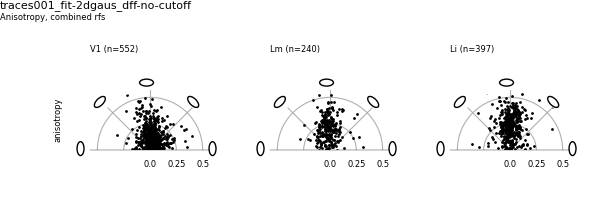

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py:160: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['0$^\circ$', '', '90$^\circ$', '', '', '', '-90$^\circ$', ''])


In [149]:
%matplotlib notebook
markersize=1
alpha=1
fontsize=6

cmap='spring_r'
metric='anisotropy'
rf_names = np.arange(-90, 90+45, 45)
rf_color='k'
ell_icon_height = 5

fig, axn = pl.subplots(1, 3, subplot_kw=dict(projection='polar'), figsize=(6,2))
for va, vg in aggdf.groupby(['visual_area']):
    ai= visual_areas.index(va)
    ax = axn[ai]
    #ax = fig.add_subplot(2, 3, ai+3+1, projection="polar")
    thetas = vg['theta_Mm_c'].values #% np.pi # all thetas should point the same way
    ratios = vg['anisotropy'].values
    ax.scatter(thetas, ratios, marker='o', s=markersize, c='k', zorder=10000) #c=area_colors[va])
    pplot.adjust_polar_axes(ax)
    if ai!=0:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('anisotropy', fontsize=fontsize, labelpad=20)
        #ax.set_xlabel('theta', fontsize=fontsize, labelpad=0)
    ax.set_title('%s (n=%i)' % (va, len(vg)), fontsize=6, loc='left')
    # ticks
    ax.set_xlabel('')
    ax.set_theta_zero_location("N")
    ax.set_xlim([-np.pi/2., np.pi/2.])
    ax.set_xticks(np.arange(-np.pi/2., np.pi/2. + (np.pi/4.), np.pi/4.))
    pplot.replace_rf_labels(rf_names, ax=ax, alpha=alpha,
                    width=ell_icon_height*2., height=ell_icon_height, color='k', 
                    yloc=yloc, lw=1, box_alignment=(1, 1), 
                    xybox=(-ell_icon_height/2., 1))
    #ax.set_yticklabels([])
    ylim = 0.57
    ytick_lim = np.floor(ylim*10)/10.
    ax.set_ylim([0, ylim])
    yloc = ax.get_ylim()[-1]*1.1 # + 4
    ax.set_yticks(np.linspace(0, ytick_lim, 3))
    ax.set_yticklabels(np.linspace(0, ytick_lim, 3))

pl.subplots_adjust(top=0.7, left=0.15, right=0.95, bottom=0.1, wspace=0.5)

pplot.label_figure(fig, data_id)
fig.text(0, 0.9, 'Anisotropy, combined rfs')
pl.savefig(os.path.join(curr_dst_dir, 'anisotropy_bw.svg'))

In [150]:
plot_metrics = ['std_avg', 'fx', 'fy']
pplot.print_means(aggdf, groupby=['visual_area'], params=plot_metrics,
                 metric='median')

[median]:
  visual_area    std_avg         fx        fy  std_avg_std    fx_std    fy_std
0          Li  14.116143  15.711789  3.888427     3.212069  6.264079  5.899129
1          Lm  10.748560  11.661073  3.268624     3.388759  4.937433  4.397960
2          V1   8.847251   9.115061  2.910005     2.281047  3.755558  3.392994


In [151]:
importlib.reload(pplot)

<module 'analyze2p.plotting' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py'>

<IPython.core.display.Javascript object>


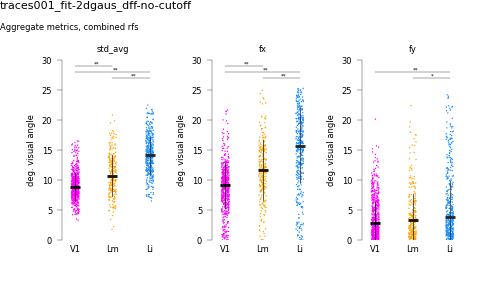

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/combined_rfs size_metrics_byCELL


In [161]:
%matplotlib notebook
plot_str='byCELL'
y_loc=27
offset=1
plot_metrics = ['std_avg', 'fx', 'fy']
multi_comp_test='fdr_bh'
markersize=1
mean_type='median'
ylim = (0, 30)
fig, axn = pl.subplots(1,len(plot_metrics),figsize=(5,3), sharey=False)
for ai, metric in enumerate(plot_metrics):
    ax=axn[ai]
    pplot.stripplot_metric_by_area(aggdf, metric, area_colors=area_colors,
                                markersize=1, ylim=ylim, ax=ax,
                                sig_fontsize=4, jitter=True, 
                                plot_means=True, y_loc=y_loc, offset=offset,
                                mean_style='point', mean_type=mean_type, 
                                aspect=2, axis_offset=4)
    ax.set_ylabel('deg. visual angle')
    ax.set_title(metric, fontsize=fontsize)
pl.subplots_adjust(top=0.8, left=0.1, right=0.95, bottom=0.2)
pplot.label_figure(fig, data_id)

fig.text(0, 0.9, 'Aggregate metrics, combined rfs')
figname = 'size_metrics_%s' % plot_str
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

<IPython.core.display.Javascript object>


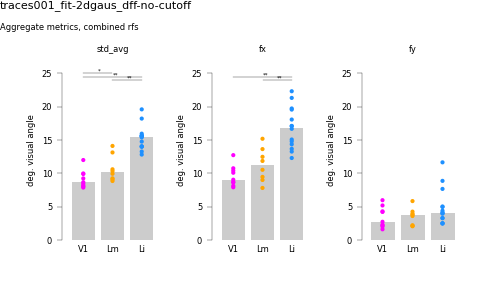

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/combined_rfs size_metrics_byFOV


In [162]:
plot_str='byFOV'
y_loc=24
offset=0.5
plot_metrics = ['std_avg', 'fx', 'fy']
multi_comp_test='fdr_bh'
markersize=1
mean_type='median'
ylim = (0, 27)

fov_df = aggdf.groupby(['visual_area', 'datakey', 'experiment']).median().reset_index()

fig, axn = pl.subplots(1,len(plot_metrics),figsize=(5,3), sharey=False)
for ai, metric in enumerate(plot_metrics):
    ax=axn[ai]
    pplot.stripplot_metric_by_area(fov_df, metric, area_colors=area_colors,
                                markersize=3, ylim=ylim, ax=ax,
                                sig_fontsize=4, jitter=False, 
                                plot_means=True, y_loc=y_loc, offset=offset,
                                mean_style='bar', mean_type=mean_type, 
                                aspect=2, axis_offset=4)
    ax.set_ylabel('deg. visual angle')
    ax.set_title(metric, fontsize=fontsize)
pl.subplots_adjust(top=0.8, left=0.1, right=0.95, bottom=0.2)
pplot.label_figure(fig, data_id)

fig.text(0, 0.9, 'Aggregate metrics, combined rfs')
figname = 'size_metrics_%s' % plot_str
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [154]:
fov_df[['visual_area', 'datakey', 'std_avg']]

,visual_area,datakey,std_avg
0,Li,20190522_JC089_fov1,19.595703
1,Li,20190522_JC089_fov1,15.623894
2,Li,20190527_JC092_fov3,12.816596
3,Li,20190528_JC092_fov1,15.667400
4,Li,20190602_JC091_fov1,14.061002
5,Li,20190602_JC091_fov1,14.017116
6,Li,20190609_JC099_fov1,14.763455
7,Li,20190614_JC091_fov1,13.267385
8,Li,20190617_JC099_fov1,15.522970
9,Li,20191012_JC113_fov1,18.212432


#### Overlap v. distance

In [78]:
# Calculate overlaps and distance (pairwise)
rf_fit_params = ['cell', 'std_x', 'std_y', 'theta', 'x0', 'y0']
# Convert RF fit params to polygon
d_=[]
for (va, dk), rfs_ in aggdf.groupby(['visual_area', 'datakey']):
    rois_ = rfs_['cell'].unique()
    if (va, dk) not in final_rf_keys:
        continue      
    rf_polys = rfutils.rfs_to_polys(rfs_[rf_fit_params])
    overlaps_ = rfutils.get_rf_overlaps(rf_polys)
    rfs_.index = rfs_['cell'].values
    # Coords of cell1 in pair, in order
    coords1 = np.array(rfs_.loc[overlaps_['poly1'].values][['ml_pos', 'ap_pos']])
    # Coords of cell2 in pair 
    coords2 = np.array(rfs_.loc[overlaps_['poly2'].values][['ml_pos', 'ap_pos']])
    # Get dists, in order of appearance
    dists = [np.linalg.norm(c1-c2) for c1, c2 in zip(coords1, coords2)]
    overlaps_['cortical_distance'] = dists
    overlaps_['visual_area'] = va
    overlaps_['datakey'] = dk
    d_.append(overlaps_)
overlaps = pd.concat(d_)
overlaps = overlaps.rename(columns={'poly1': 'cell_1', 'poly2': 'cell_2'})

In [79]:
overlaps[['visual_area', 'datakey']]\
    .drop_duplicates()['visual_area'].value_counts()

Li    12
V1     9
Lm     8
Name: visual_area, dtype: int64

In [80]:
overlaps.head()

,cell_1,cell_2,area_overlap,perc_overlap,cortical_distance,visual_area,datakey
0,116.0,121.0,0.452186,0.737842,59.145341,Li,20190522_JC089_fov1
0,116.0,122.0,0.476668,0.974101,80.706373,Li,20190522_JC089_fov1
0,116.0,130.0,0.599980,0.894683,272.596672,Li,20190522_JC089_fov1
0,116.0,145.0,0.559354,0.758723,139.574437,Li,20190522_JC089_fov1
0,116.0,146.0,0.405485,0.788676,346.653270,Li,20190522_JC089_fov1


In [81]:
# Bin cortical distances for plotting
n_bins_dist = 6
n_bins_overlap = 8

use_quartile=False
bin_type = 'eqpop%i' % n_bins_dist if use_quartile else 'eqwidth%i' % n_bins_dist
print("binning: %s" % bin_type)

if use_quartile:
    overlaps['binned_dist'], bin_edges = pd.qcut(overlaps['cortical_distance'], \
                                    n_bins_dist, labels=False, retbins=True)
    #roi_df['binned_overlap'] = pd.cut(roi_df['perc_overlap'], n_bins_overlap, labels=False)
else:
    overlaps['binned_dist'], bin_edges = pd.cut(overlaps['cortical_distance'], \
                                     n_bins_dist,labels=False, retbins=True)
    #roi_df['binned_overlap'] = pd.cut(roi_df['perc_overlap'], n_bins_overlap, labels=False)

binning: eqwidth6


In [82]:
meanf = overlaps.groupby(['visual_area', 'datakey', 'binned_dist'])\
                .mean().reset_index()

<IPython.core.display.Javascript object>


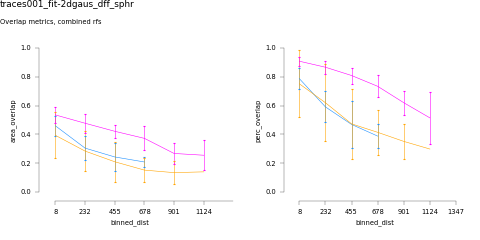

In [84]:
lw=0.5
fig, axn = pl.subplots(1,2, figsize=(6,3), sharex=True, sharey=False)
for ax, metric in zip(axn.flat, ['area_overlap', 'perc_overlap']):
    sns.lineplot(x='binned_dist', y=metric, data=meanf, ax=ax,
                 hue='visual_area', palette=area_colors, 
                 ci='sd', err_style='bars',
                err_kws={'capsize':1, 'lw': lw}, lw=lw)
    ax.set_xticks(list(range(len(bin_edges))))
    ax.set_xticklabels([round(i) for i in bin_edges])
    ax.set_ylim([0, 1])
    sns.despine(offset=8, trim=True, ax=ax)
    ax.legend_.remove()
pl.subplots_adjust(top=0.8, left=0.1, right=0.95, bottom=0.2, wspace=0.5, hspace=0.5)

p3.label_figure(fig, data_id)
fig.text(0, 0.9, 'Overlap metrics, combined rfs')
pl.savefig(os.path.join(curr_dst_dir, 'overlap_by_distance.svg'))

<IPython.core.display.Javascript object>


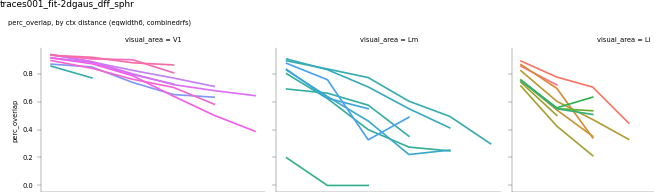

In [85]:
# fig, ax = pl.sublots()
metric = 'perc_overlap'
fg = sns.relplot(x='binned_dist', y=metric, hue='datakey',
                 data=meanf,col='visual_area', col_order=visual_areas,
                 kind='line', height=3)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)
fg.fig.text(0.01, 0.9, '%s, by ctx distance (%s, %s)' % (metric, bin_type, rf_type))
pl.xticks(list(range(len(bin_edges))))
fg.axes.flat[0].set_xticklabels([round(i) for i in bin_edges])
pl.subplots_adjust(left=0.05, right=0.9)
# fg.axes.flat[0].legend_.remove()
p3.label_figure(fg.fig, data_id)

figname =  'perFOV_%s_by_dist' % (metric)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))


In [87]:
curr_dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/combined_rfs'

# On screen

In [88]:
# Convert to degrees
screen = p3.get_screen_dims()
screen_max = screen['azimuth_deg']/2.
screen_min = -screen_max

In [89]:
import retino_utils as retutils

In [97]:
def get_retino_metadata(sdata, 
                    roi_type='pixels', traceid=None,
                    return_errors=False,
                    rootdir='/n/coxfs01/2p-data', 
                    aggregate_dir='/n/coxfs01/julianarhee/aggregate-visual-areas'):
    '''
    Gets analysis ID info for ROI-based retino analyses.
    '''
    meta_list=[]
    no_retino=[]
    errors=[]
    for (va, dk, animalid, session, fov), g in \
                sdata.groupby(['visual_area', 'datakey', 'animalid', 'session', 'fov']):
        exp_list = [e for e in g['experiment'].values if 'retino' in e] 
        if len(exp_list)==0:
            print('... skipping, no retino (%s, %s, %s)' % (animalid, session, fov)) 
            continue
        retino_dirs = glob.glob(os.path.join(rootdir, animalid, session, fov,\
                                        'retino_*', 'retino_analysis'))
        # get analysis ids for non-pixel
        for retino_dir in retino_dirs:
            retinorun = os.path.split(os.path.split(retino_dir)[0])[-1]
            if traceid is None:
                try:
                    rid_fpath = glob.glob(os.path.join(retino_dir, 
                                                       'analysisids_*.json'))[0]
                    with open(rid_fpath, 'r') as f:
                        retids = json.load(f)
                    retids = [r for r, res in retids.items() \
                                if res['PARAMS']['roi_type']==roi_type] 
                    assert len(retids)>0, "No ROI-based analyses"
                except AssertionError as e:
                    #print("ERROR")
                    no_retino.append(retino_dir)
                    continue
                except Exception as e:
                    print('ERROR', e)
                    no_retino.append(retino_dir)
                    continue
                for retid in retids: 
                    try:
                        fpath = os.path.join(rootdir, animalid, session, fov, retinorun,
                                    'retino_analysis', 'retino_structure', \
                                      'projections_%s.pkl' %  va)
                        assert os.path.exists(fpath), \
                            "No projection results (%s, %s, %s)" % (va, dk, retid)
                        meta_list.append(
                            tuple([va, animalid, session, fov, retinorun, retid, fpath]))
                    except Exception as e:
                        print(e)
                        errors.append((retino_dir, retid))
                        continue
            else:
                fpath = os.path.join(rootdir, animalid, session, fov, retinorun,
                        'retino_analysis', 'retino_structure', \
                                  'projections_%s.pkl' %  va)
                meta_list.append(
                    tuple([va, animalid, session, fov, retinorun, traceid, fpath]))
    retmeta = pd.DataFrame(meta_list, 
        columns=['visual_area', 'animalid', 'session', \
                 'fov', 'retino_run', 'analysis_id','proj_path'])
    if return_errors:
        return retmeta, no_retino, errors
    else:
        return retmeta

In [91]:
import retino_utils as retutils

In [92]:
#### Filter RETINO datasets by
pass_criterion='pixels'
mag_thr = 0.003
mag_thr = 0.1 if pass_criterion=='npmean' else mag_thr
##### Results key identifier
magthr_str = '%s_thr-%.3f' % (pass_criterion, mag_thr)
print(magthr_str)

pixels_thr-0.003


In [93]:
retmeta = pd.concat([g for (va, dk), g in sdata.groupby(['visual_area', 'datakey'])\
            if ('retino' in g['experiment'].values)])
ret_keys = list((va, dk) for (va, dk) in \
                retmeta[['visual_area', 'datakey']].drop_duplicates().values)

In [98]:
print("Threshold info: %s" % magthr_str)
retino_meta, no_ret, errs = get_retino_metadata(retmeta, roi_type='pixels',
                                                return_errors=True, traceid=None)
# retino_meta = get_projection_result_paths(retino_meta)
print("%i without ROI analysis" % len(no_ret))
for r in no_ret: print('... %s' % r)
print("%i ERR loading projection vectors" % len(errs))
for r in errs: print('... %s' % str(r))
retino_meta = p3.add_datakey(retino_meta)

Threshold info: pixels_thr-0.003
ERROR list index out of range
No projection results (Li, 20190327_JC073_fov1, analysis001)
No projection results (Li, 20190327_JC073_fov1, analysis001)
No projection results (Lm, 20190314_JC070_fov2, analysis001)
No projection results (Lm, 20190327_JC073_fov1, analysis001)
No projection results (Lm, 20190327_JC073_fov1, analysis001)
No projection results (Lm, 20190422_JC076_fov1, analysis001)
No projection results (V1, 20190508_JC083_fov1, analysis001)
1 without ROI analysis
... /n/coxfs01/2p-data/JC070/20190314/FOV1_zoom2p0x/retino_run2/retino_analysis
7 ERR loading projection vectors
... ('/n/coxfs01/2p-data/JC073/20190327/FOV1_zoom2p0x/retino_run1/retino_analysis', 'analysis001')
... ('/n/coxfs01/2p-data/JC073/20190327/FOV1_zoom2p0x/retino_run2/retino_analysis', 'analysis001')
... ('/n/coxfs01/2p-data/JC070/20190314/FOV2_zoom2p0x/retino_run1/retino_analysis', 'analysis001')
... ('/n/coxfs01/2p-data/JC073/20190327/FOV1_zoom2p0x/retino_run1/retino_anal

In [99]:
def delete_files(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))
    return
import shutil
# Create dir to copy gradient images to, for visual inspection
copy_images = True
dst = os.path.join(curr_dst_dir, 'gradient_maps')
if not os.path.exists(dst):
    os.makedirs(dst)
if copy_images:
    delete_files(dst)
print(dst)


/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/combined_rfs/gradient_maps


In [100]:

def copy_gradient_maps(fpath, dst, prefix=None):
    src = os.path.split(fpath)[0]
    fimpaths = glob.glob(os.path.join(src, 'gradients*.svg'))
    fimpaths.extend(glob.glob(os.path.join(src, 'unitvec*.svg')))
    if len(fimpaths)==0:
        fimpaths = glob.glob(os.path.join(src, 'gradients*.png'))
        fimpaths.extend(glob.glob(os.path.join(src, 'unitvec*.png')))
    for fimpath in fimpaths:
        fname, fext = os.path.splitext(os.path.split(fimpath)[-1])
        fn = 'gradients' if 'gradients' in fname else 'unitvec'
        if prefix is None:
            new_fn = fname
        else:
            new_fn ='%s_%s%s' % (prefix, fn, fext)
        shutil.copyfile(fimpath, os.path.join(dst, new_fn))

In [101]:
d_list=[]
cols = ['visual_area', 'datakey', 'retino_run', 'analysis_id', 'proj_path']
for di, (va, dk, retinorun, retinoid, fpath) in enumerate(retino_meta[cols].values):
    if di % 20 == 0 or di==(len(retino_meta)-1):
        print("%i of %i gradient result files loaded." % (int(di+1), len(retino_meta)))
    with open(fpath, 'rb') as f:
        res = pkl.load(f, encoding='latin1')
    tmpd = res['regr_df'].copy()
    metainfo = {'visual_area': va,  'datakey': dk, 
                'retinorun': retinorun, 'retinoid': retinoid, 'fpath':fpath}
    tmpd = p3.add_meta_to_df(tmpd, metainfo)
    d_list.append(tmpd)
    if copy_images:
        prefix= '%s_%s_%s' % (va, dk, retinorun)
        copy_gradient_maps(fpath, dst, prefix=None)
    
projection_df = pd.concat(d_list, axis=0).reset_index(drop=True)
projection_df['abs_coef'] = abs(projection_df['coefficient'])
projection_df['cortical_mag'] = 1./projection_df['abs_coef']

1 of 84 gradient result files loaded.
21 of 84 gradient result files loaded.
41 of 84 gradient result files loaded.
61 of 84 gradient result files loaded.
81 of 84 gradient result files loaded.
84 of 84 gradient result files loaded.


In [87]:
#     with open(fpath, 'rb') as f:
#         res = pkl.load(f, encoding='latin1')
#     tmpd = res['regr_df'].copy()
#     tmpd

In [88]:
#     src = os.path.split(fpath)[0]
#     fimpaths = glob.glob(os.path.join(src, 'gradients*.svg'))
#     fimpaths.extend(glob.glob(os.path.join(src, 'unitvec*.svg')))
#     if len(fimpaths)==0:
#         fimpaths = glob.glob(os.path.join(src, 'gradients*.png'))
#         fimpaths.extend(glob.glob(os.path.join(src, 'unitvec*.png')))

In [89]:
# fimpaths

In [102]:
# Drop repeated retino run
best_retino = retutils.select_strongest_retinorun(projection_df)
best_retino['retinokey'] = ['%s_%s' % (dk, rrun) for dk, rrun \
                            in best_retino[['datakey', 'retinorun']].values]
print(projection_df.shape, best_retino.shape)

(168, 14) (144, 15)


In [103]:
# Select FOVs with BOTH azimuth and elevation passed
retino_r2_thr=0.5
projdf = pd.concat([g for (varea, datakey, retinorun), g \
                in best_retino.groupby(['visual_area', 'datakey', 'retinorun']) \
                if ((g[g['cond']=='az']['R2'].values > retino_r2_thr) \
                and (g[g['cond']=='el']['R2'].values > retino_r2_thr))])
print(best_retino.shape, projdf.shape)

(144, 15) (126, 15)


In [104]:
# Match retino + RF datasets
all_retino_keys = list([tuple(v) for v in projdf[['visual_area', 'datakey']]\
                    .drop_duplicates().values])
rf_df = pd.concat([g for (va, dk), g in avgrfs.groupby(['visual_area', 'datakey'])\
                  if (va, dk) in all_retino_keys])

all_rf_keys = list([tuple(v) for v in rf_df[['visual_area', 'datakey']]\
                    .drop_duplicates().values])

# Select best RF by # cells (out of the retinos that pass)
final_counts = rf_df.groupby(['visual_area', 'datakey'])['cell'].count().reset_index()
print(len(all_rf_keys), len(all_retino_keys))
best_ = p3.select_best_fovs(final_counts, criterion='max')
final_rf_keys = list((va, dk) for (va, dk) in \
                     best_[['visual_area', 'datakey']].values)

41 63
[V1] Animalid does not exist: JC078 


In [105]:
final_dkeys = [k for k in all_retino_keys if k in final_rf_keys]
print(len(final_dkeys), len(final_rf_keys))

27 27


In [106]:
final_proj = pd.concat([g for (va, dk), g in projdf.groupby(['visual_area', 'datakey']) \
                        if (va, dk) in final_dkeys])
final_rfs = pd.concat([g for (va, dk), g in avgrfs.groupby(['visual_area', 'datakey']) \
                        if (va, dk) in final_dkeys])


In [107]:
final_proj[['visual_area', 'datakey']].drop_duplicates()\
.groupby(['visual_area']).count()

,datakey
visual_area,
Li,11
Lm,7
V1,9


In [108]:
retinodf = pd.concat([ret_ for (va, dk), ret_ in projdf.groupby(['visual_area', 'datakey']) \
                       if (va, dk) in final_rf_keys])

In [109]:
retinodf[['visual_area', 'datakey', 'retinorun']].drop_duplicates()\
.groupby(['visual_area']).count()

,datakey,retinorun
visual_area,,
Li,11,11
Lm,7,7
V1,9,9


In [110]:
aggdf[['visual_area', 'datakey']].drop_duplicates()\
.groupby(['visual_area']).count()

,datakey
visual_area,
Li,12
Lm,8
V1,9


In [424]:
# final_rfs = aggdf.copy()
# final_proj = retinodf.copy()

In [111]:
def add_transformed_positions(final_rfs, final_proj):
    '''
    Load projection vectors (vectors_VA.pkl) provided by final_proj.
    Apply transform to ROI positions, 
    i.e., convert [ap_pos, ml_pos] --> [ml_proj, ap_proj]
    '''
    f0 = final_rfs.copy()
    f0['ml_proj'] = None
    f0['ap_proj'] = None
    for (va, dk), rfs_ in final_rfs.groupby(['visual_area', 'datakey']):
        ret_ = final_proj[(final_proj['visual_area']==va) 
                        & (final_proj['datakey']==dk)].copy()
        if ret_.shape[0]==0:
            print("... no pass retino: (%s, %s)" % (va, dk))
            continue
        # Get gradient_results path (vectors_VA.pkl) and load projection vectors
        assert len(ret_['fpath'].unique())==1, "[%s] Found retino path found: %s" \
                                            % (dk, str(ret_['fpath'].unique()))
        fpath = ret_['fpath'].unique()[0]
        gpaths = glob.glob(os.path.join(os.path.split(fpath)[0],
                                        'vectors_%s.pkl' % va))
        gpaths = [f for f in gpaths if '_pixels_thr' not in f] 
        assert len(gpaths)==1, "[%s, %s] Found retino path found: %s" \
                                                    % (dk, exp, str(gpaths))
        with open(gpaths[0], 'rb') as f:
            gresults = pkl.load(f, encoding='latin1')
        # Project FOV coordinates
        f0.loc[rfs_.index, 'ml_proj'] =np.array([np.dot(np.array((ml, ap)), gresults['az']) \
                                              for ap, ml in rfs_[['ap_pos', 'ml_pos']].values])
        f0.loc[rfs_.index, 'ap_proj'] = np.array([np.dot(np.array((ml, ap)), gresults['el']) \
                                              for ap, ml in rfs_[['ap_pos', 'ml_pos']].values])
    return f0
    

In [112]:
def filter_gradient_fits(final_proj, pass_crit='both', fit_thr=0.5):
    '''
    Filter gradient fits (projections) for retino data.
    '''
    if pass_crit=='both':
        filtproj = pd.concat([g for k, g in final_proj.groupby(['visual_area', 'datakey', 'retinorun']) \
                                if ((g[g['cond']=='az']['R2'].values>fit_thr) \
                                    and (g[g['cond']=='el']['R2'].values>fit_thr))])
    else:
        filtproj = pd.concat([g for k, g in final_proj.groupby(['visual_area', 'datakey', 'retinorun']) \
                                if ((g[g['cond']=='az']['R2'].values>fit_thr) \
                                    or (g[g['cond']=='el']['R2'].values>fit_thr))])
    return filtproj

In [113]:
def calculate_scatter_metrics_split_exp(final_rfs, final_proj, min_ncells=5):
    not_enough_cells_fit = []
    bad_fits = []
    d_list = []
    for (visual_area, datakey, rfname), rfs_ in \
                final_rfs.groupby(['visual_area','datakey', 'experiment']): #['V1', 'Lm', 'Li']:    
        if rfs_.shape[0] < min_ncells:
            print("--- too few cells (min%i), %s" % (min_ncells, datakey))
            not_enough_cells_fit.append(datakey)
            continue
        if datakey not in curr_gradients['datakey'].unique():
            print("--- bad gradient, %s" % datakey)
            continue
        # Get retino gradient
        ret_ = final_proj[(final_proj['visual_area']==visual_area) 
                            & (final_proj['datakey']==datakey)].copy()
        for cond, ret_cond in ret_.groupby(['cond']):
            xname = 'ml' if cond=='az' else 'ap'
            yname = 'x0' if cond=='az' else 'y0'
            max_degrees = screen['azimuth_deg']*20. if cond=='az' \
                                else screen['altitude_deg']*20.
            max_fovdist = 1177*20. if cond=='ap' else 972.*20.
            # Get RF fit info
            proj_locs = np.array(rfs_['%s_proj' % xname].values)
            rf_locs = np.array(rfs_[yname].values)
            rf_cell_ids = rfs_['cell'].values
            # Get dist to line:
            slope = float(ret_cond['coefficient'])
            intercept = float(ret_cond['intercept'])
            r2 = float(ret_cond['R2'])
            predicted_rf_locs = slope*proj_locs + intercept
            # Calculate DEG and DIST scattered
            deg_sc = abs(rf_locs - predicted_rf_locs).astype(float)
            deg_ixs = [i for i, v in enumerate(deg_sc) if v < max_degrees] # filter out illegal vals
            dist_sc = abs(proj_locs - (rf_locs - intercept)/slope).astype(float)
            dist_ixs = [i for i, v in enumerate(dist_sc) if v < max_fovdist] # filter out illegal vals
            # Only keep if both deg + dist calculated
            keep_ixs = np.intersect1d(deg_ixs, dist_ixs)
            n_pts = len(keep_ixs)
            if (n_pts)==0:
                bad_fits.append((datakey, cond))
                continue
            #print("... (%s) deg: %i of %i in bounds" % (cond, len(deg_ixs), len(deg_sc)))
            #print("... (%s) dist: %i of %i in bounds" % (cond, len(dist_ixs), len(dist_sc)))
            assert len(rf_cell_ids)==len(deg_sc)

            if any(np.isnan(dist_sc)):
                print(visual_area, datakey, r2)
                break
            if any(np.isnan(deg_sc)):
                print(visual_area, datakey, r2, deg_sc)
                break
            tmpd=pd.DataFrame({'cell': rf_cell_ids[keep_ixs],
                               'deg_scatter': deg_sc[keep_ixs],
                               'dist_scatter': dist_sc[keep_ixs],
                               'measured_rf': rf_locs[keep_ixs],
                               'predicted_rf': predicted_rf_locs[keep_ixs],
                               'measured_loc': proj_locs[keep_ixs],
                               'predicted_loc': (rf_locs[keep_ixs] - intercept)/slope,
                               'retino_R2': [r2 for _ in np.arange(0, n_pts)],
                               'axis': [cond for _ in np.arange(0, n_pts)],
                               'visual_area': [visual_area for _ in np.arange(0, n_pts)],
                               'datakey': [datakey for _ in np.arange(0, n_pts)],
                               'rfname': [rfname for _ in np.arange(0, n_pts)]
                         })
            d_list.append(tmpd)
    scatdf = pd.concat(d_list, axis=0)
    return scatdf

def calculate_scatter_metrics(final_rfs, final_proj, min_ncells=5):
    not_enough_cells_fit = []
    bad_fits = []
    d_list = []
    for (va, dk), rfs_ in final_rfs.groupby(['visual_area','datakey']):
        if rfs_.shape[0] < min_ncells:
            print("--- too few cells (min%i), %s" % (min_ncells, dk))
            not_enough_cells_fit.append(dk)
            continue
        if dk not in final_proj['datakey'].unique():
            print("--- bad gradient, %s" % dk)
            continue
        # Get retino gradient
        ret_ = final_proj[(final_proj['visual_area']==va) 
                            & (final_proj['datakey']==dk)].copy()
        if ret_.shape[0]==0:
            print("none:: %s" % dk)
        for cond, ret_cond in ret_.groupby(['cond']):
            xname = 'ml' if cond=='az' else 'ap'
            yname = 'x0' if cond=='az' else 'y0'
            max_degrees = screen['azimuth_deg']*20. if cond=='az' \
                                else screen['altitude_deg']*20.
            max_fovdist = 1177*20. if cond=='ap' else 972.*20.
            
            # Get RF fit info
            proj_locs = np.array(rfs_['%s_proj' % xname].values)
            #print(va, dk, cond, proj_locs)
            rf_locs = np.array(rfs_[yname].values)
            rf_cell_ids = rfs_['cell'].values
            # Get dist to line:
            slope = float(ret_cond['coefficient'])
            intercept = float(ret_cond['intercept'])
            r2 = float(ret_cond['R2'])
            predicted_rf_locs = slope*proj_locs + intercept
            # Calculate DEG and DIST scattered
            deg_sc = abs(rf_locs - predicted_rf_locs).astype(float)
            deg_ixs = [i for i, v in enumerate(deg_sc) if v < max_degrees] # filter out illegal vals
            dist_sc = abs(proj_locs - (rf_locs - intercept)/slope).astype(float)
            dist_ixs = [i for i, v in enumerate(dist_sc) if v < max_fovdist] # filter out illegal vals
            # Only keep if both deg + dist calculated
            keep_ixs = np.intersect1d(deg_ixs, dist_ixs)
            n_pts = len(keep_ixs)
            if (n_pts)==0:
                bad_fits.append((datakey, cond))
                continue
            #print("... (%s) deg: %i of %i in bounds" % (cond, len(deg_ixs), len(deg_sc)))
            #print("... (%s) dist: %i of %i in bounds" % (cond, len(dist_ixs), len(dist_sc)))
            assert len(rf_cell_ids)==len(deg_sc)
            tmpd=pd.DataFrame({
                       'cell': rf_cell_ids[keep_ixs],
                       'deg_scatter': deg_sc[keep_ixs],
                       'dist_scatter': dist_sc[keep_ixs],
                       'measured_rf': rf_locs[keep_ixs],
                       'predicted_rf': predicted_rf_locs[keep_ixs],
                       'measured_loc': proj_locs[keep_ixs],
                       'predicted_loc': (rf_locs[keep_ixs] - intercept)/slope})
            tmpd['retino_R2'] = r2
            tmpd['axis'] = cond
            tmpd['visual_area'] = va
            tmpd['datakey'] = dk
            tmpd['rfname'] = 'combined'
            d_list.append(tmpd)
    scatdf = pd.concat(d_list, axis=0)
    return scatdf

def combine_scatter_metrics(scatdf):
    all_cols = [k for k in scatdf.columns if k!='dist_scatter']
    sd1 = scatdf[all_cols].copy().rename(columns={'deg_scatter': 'scatter_val'})
    sd1['scatter_label'] = 'vf_deg'

    all_cols = [k for k in scatdf.columns if k!='deg_scatter']
    sd2 = scatdf[all_cols].copy().rename(columns={'dist_scatter': 'scatter_val'})
    sd2['scatter_label'] = 'ctx_dist'

    sd = pd.concat([sd1, sd2], axis=0)
    return sd


In [114]:
#rfname = 'rfs10'
min_ncells=5
retino_r2_thr=0.75
retino_pass_crit='both' 
final_rfs = add_transformed_positions(final_rfs, final_proj)
# Filter gradient data
curr_gradients = filter_gradient_fits(final_proj, pass_crit=retino_pass_crit,
                                      fit_thr=retino_r2_thr)
scatdf = calculate_scatter_metrics(final_rfs, curr_gradients, min_ncells=5)
print(scatdf.shape)

sd = combine_scatter_metrics(scatdf)
mean_sc = sd.groupby(['visual_area', 'datakey', 'axis',  'scatter_label']).mean().reset_index()

--- bad gradient, 20190607_JC091_fov1
--- bad gradient, 20190612_JC099_fov1
--- too few cells (min5), 20191012_JC113_fov1
--- bad gradient, 20190517_JC083_fov1
(1960, 12)


In [115]:
axis_palette={'az': [0.8]*3, 'el': [0.6]*3}

In [116]:
#rfname = 'rfs10'
min_ncells=5
retino_r2_thr=0.5
retino_pass_crit='both' 
all_rfs = add_transformed_positions(rf_df, projdf)
# Filter gradient data
all_gradients = filter_gradient_fits(projdf, pass_crit=retino_pass_crit,
                                      fit_thr=retino_r2_thr)
scatdf_all = calculate_scatter_metrics(all_rfs, all_gradients, min_ncells=5)
print(scatdf_all.shape)
scat_comb_all = combine_scatter_metrics(scatdf_all)
mean_sc_all = scat_comb_all.groupby(['visual_area', 'datakey', 'axis',  'scatter_label']).mean().reset_index()

--- too few cells (min5), 20191012_JC113_fov1
--- too few cells (min5), 20191111_JC120_fov1
--- too few cells (min5), 20190509_JC078_fov1
(2698, 12)


In [117]:
'20190616_JC097_fov1' in mean_sc_all['datakey'].values

True

In [118]:
s_=[]
for sc, mc in mean_sc.groupby(['scatter_label']):
    s0 = p3.paired_ttests(mc, metric='scatter_val', 
                        c1='az', c2='el', compare_var='axis', 
                        ttest=False)
    s0['scatter_label'] = sc
    s_.append(s0)
statdf = pd.concat(s_)
statdf

,t_stat,p_val,visual_area,scatter_label
0,15.0,0.742188,V1,ctx_dist
1,0.0,0.015625,Lm,ctx_dist
2,1.0,0.015625,Li,ctx_dist
0,1.0,0.015625,V1,vf_deg
1,3.0,0.078125,Lm,vf_deg
2,2.0,0.023438,Li,vf_deg


In [120]:
pplot.print_means(mean_sc, groupby=[ 'scatter_label', 'visual_area', 'axis'], 
                                  params=['scatter_val'])

[mean]:
   scatter_label visual_area axis  scatter_val  scatter_val_std
0       ctx_dist          Li   az    89.330822        46.068521
1       ctx_dist          Li   el   155.374899        51.918605
2       ctx_dist          Lm   az   129.241023        72.702387
3       ctx_dist          Lm   el   235.936680        51.034600
4       ctx_dist          V1   az   290.901882       112.401476
5       ctx_dist          V1   el   279.585408       110.859585
6         vf_deg          Li   az     7.364653         2.510264
7         vf_deg          Li   el     4.968918         1.339164
8         vf_deg          Lm   az     6.165601         2.074959
9         vf_deg          Lm   el     5.098930         1.806038
10        vf_deg          V1   az     5.299931         1.325770
11        vf_deg          V1   el     2.816061         0.552147


<IPython.core.display.Javascript object>


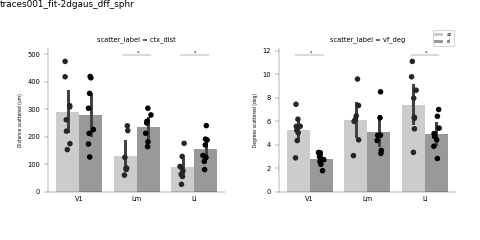

ctx_dist 497.8215667942389
vf_deg 11.66436134124201
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff_sphr/combined_rfs scatter_dist_and_deg


In [121]:
fg = sns.FacetGrid(mean_sc, col='scatter_label', height=3, aspect=1,sharey=False)
fg.map(sns.barplot, 'visual_area', 'scatter_val', 'axis', 
       order=visual_areas, hue_order=['az', 'el'], palette=axis_palette)
fg.map(sns.stripplot, 'visual_area', 'scatter_val', 'axis', dodge=True, 
       order=visual_areas, hue_order=['az', 'el'], color='k')

bar_length=0.5
offset_frac = 0.25
fontsize=4
lw=0.25
for sl, g in statdf[statdf['p_val']<0.05].groupby(['scatter_label']):
    currax = fg.axes_dict[sl]
    yloc = currax.get_ylim()[-1]
    print(sl, yloc)
    offset = np.mean(np.diff(currax.get_yticks()))*offset_frac
    for va, gg in g.groupby(['visual_area']):
        vi = visual_areas.index(va)
        currax.plot( [vi-(bar_length/2.), vi+(bar_length/2.)], [yloc, yloc], 
                    color='k', lw=lw)
        star_str = '**' if float(gg['p_val'])<0.01 else '*'
        currax.text(vi, yloc, star_str, fontsize=fontsize)
    currax.tick_params(which='both', axis='x', size=0)
    currax.set_xlabel('')
    yl = 'Distance scattered (um)' if sl=='ctx_dist' else 'Degrees scattered (deg)'
    currax.set_ylabel(yl, fontsize=fontsize)
# Legend
fg.axes.flat[1].legend()
lh = pplot.crop_legend_labels(fg.axes.flat[1], n_hues=2, start_ix=2,
                            bbox_to_anchor=(1,1), loc='lower right', fontsize=fontsize)
pl.subplots_adjust(bottom=0.2, top=0.8, right=0.95, left=0.1, wspace=0.3)

pplot.label_figure(fg.fig, data_id)
figname = 'scatter_dist_and_deg'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [874]:
sc

'vf_deg'

In [863]:
d_=[]
for (sl, va), vg in mean_sc.groupby(['scatter_label', 'visual_area']):
    a_vals = vg[vg['axis']=='az']['scatter_val'].values
    b_vals = vg[vg['axis']=='el']['scatter_val'].values
    diffs = b_vals-a_vals
    df_ = pd.DataFrame({'el_minus_az': diffs})
    df_['visual_area'] = va
    df_['scatter_label'] = sl
    d_.append(df_)
diffs = pd.concat(d_)    

In [864]:
diffs['visual_area'] = diffs['visual_area'].astype('category')

<IPython.core.display.Javascript object>


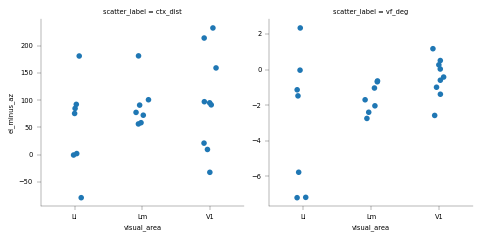

/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the stripplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


In [865]:

fg=sns.FacetGrid(diffs, col='scatter_label', height=3, sharey=False)
fg.map(sns.stripplot, 'visual_area', 'el_minus_az')

#### Scatter example

In [1568]:
va = 'V1'
dk = '20190522_JC084_fov1' #'20190617_JC097_fov1'
# dk = '20190616_JC097_fov1'

df_= scatdf_all[(scatdf_all.visual_area==va) & (scatdf_all.datakey==dk)].copy()
scatter_cols = ['cell', 'predicted_rf', 'measured_rf', 'predicted_loc', 'measured_loc']
df_[scatter_cols] = df_[scatter_cols].astype(float)


In [1569]:
df_.columns

Index(['cell', 'deg_scatter', 'dist_scatter', 'measured_rf', 'predicted_rf',
       'measured_loc', 'predicted_loc', 'retino_R2', 'axis', 'visual_area',
       'datakey', 'rfname'],
      dtype='object')

In [1573]:
nonnum = ['datakey', 'animalid', 'session', 'experiment', 'visual_area']
numcols = [k for k in final_rfs.columns if k not in nonnum]
final_rfs[numcols] = final_rfs[numcols].astype(float)

In [1574]:
rois_ = rfs_['cell'].unique()
rfs_ = final_rfs[(final_rfs.visual_area==va) & (final_rfs.datakey==dk)].copy()
rfs_0= final_rfs[(final_rfs.visual_area==va) & (final_rfs.datakey==dk)].copy()
rfs_.index=rfs_0['cell']
# Get retino gradient
ret_ = final_proj[(final_proj.visual_area==va) & (final_proj.datakey==dk)].copy()

In [1575]:
# Load boot results
session, animalid, fovn = p3.split_datakey_str(dk)
fov = 'FOV%i_zoom2p0x' % fovn
eval_results, eval_params = rfutils.load_eval_results(
                                animalid, session, fov, experiment='rfs')
bootdata = eval_results['data']
boot_ = bootdata[bootdata['cell'].isin(rois_)]
cis_ = eval_results['cis'].loc[rois_]

<IPython.core.display.Javascript object>


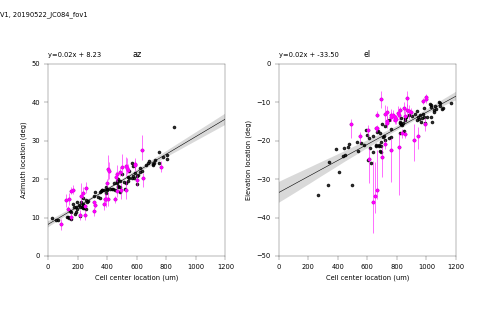

130
130
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/combined_rfs example_scatter_V1_20190522_JC084_fov1


In [1576]:
marker='o'
marker_size=5
ci = 0.95
lw=0.5
fill_marker=True
deviant_color='magenta'
scatter_kws={'s': marker_size, 'marker': marker}
line_kws={'lw': lw}

fig, axn = pl.subplots(1, 2, figsize=(6,4), sharex=True)

for ax, cond in zip(axn.flat, ['az', 'el']):
    # Get var names for V1/V2
    if cond=='az':
        ax.set_ylim([0, 50])
    else:
        ax.set_ylim([-50, 0])
    ax.set_xlim([0, 1200])
    xname = 'ml_proj' if cond=='az' else 'ap_proj'
    yname = 'x0' if cond=='az' else 'y0'
    # Get projected cortical position
    ax = rfutils.fit_with_deviants(boot_, cis_, rfs_, xname=xname, yname=yname, ax=ax,
                          scatter_kws=scatter_kws, line_kws=line_kws, 
                          deviant_color=deviant_color,lw=lw)
    ax.set_title(cond)
    ylabel='Azimuth' if cond=='az' else 'Elevation'
    ax.set_ylabel('%s location (deg)' % ylabel)
    ax.set_xlabel('Cell center location (um)')
    currd = df_[df_.axis==cond].copy()
    # should be equivalent to'measured_loc' and 'measured_rf' in SCATTERDF:
#     sns.scatterplot(x='measured_loc', y='measured_rf', data=currd, ax=ax,
#                    color='cyan', alpha=0.5)
        
fig.text(0, 0.95, '%s, %s' % (va, dk))
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8, wspace=0.3)

pplot.label_figure(fg.fig, data_id)
figname = 'example_scatter_%s_%s' % (va, dk)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)
